In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string
import unicodedata

import json
import nltk

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.util import ngrams
from nltk import pos_tag
from nltk import RegexpParser


from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, roc_curve, auc

In [6]:
! ls

dataset-examples      spark capstone2.ipynb yelp_dataset
sarc_09-12.csv        viewing data.ipynb


## Load and convert data ##

In [7]:
# read in Yelp Reviews
  
data = [json.loads(line) for line in open('yelp_dataset/yelp_academic_dataset_review.json', 'r')]

In [91]:
reviews_df = pd.DataFrame(data)

In [92]:
reviews_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,lWC-xP3rd6obsecCYsGZRg,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4.0,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02
1,8bFej1QE5LXp4O05qjGqXA,YoVfDbnISlW0f7abNQACIg,RA4V8pr014UyUbDvI-LW2A,4.0,1,0,0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25
2,NDhkzczKjLshODbqDoNLSg,eC5evKn1TWDyHCyQAwguUw,_sS2LBIGNT5NQb6PD1Vtjw,5.0,0,0,0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06
3,T5fAqjjFooT4V0OeZyuk1w,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2.0,1,1,1,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15
4,sjm_uUcQVxab_EeLCqsYLg,0kA0PAJ8QFMeveQWHFqz2A,8zehGz9jnxPqXtOc7KaJxA,4.0,0,0,0,The food is always great here. The service fro...,2011-07-28 18:05:01


In [93]:
len(reviews_df)

8635403

In [95]:
# get 200k toy dataframe of balanced funny/not funny reviews

len(reviews_df[reviews_df.funny >= 3])

340864

In [97]:
funny_df = reviews_df[reviews_df.funny >= 3].sample(n=100000, random_state=1)
not_funny_df = reviews_df[reviews_df.funny == 0].sample(n=100000, random_state=1)

In [98]:
# save toy datasets to csv

funny_df.to_csv('funny.csv')
not_funny_df.to_csv('notfunny.csv')

In [3]:
# read in and concatenate

funny_df = pd.read_csv('funny.csv')
not_funny_df = pd.read_csv('notfunny.csv')

df = pd.concat([funny_df, not_funny_df]).drop_duplicates('review_id')
df.shape

(200000, 10)

In [4]:
df = df.drop(['Unnamed: 0'], axis = 1)

In [5]:
df = df.reset_index(drop=True)

In [6]:
df.text

0         A scavenger hunt was hosted by the Paramount r...
1         The Pretty Kitty has 20 locations throughout t...
2         After a very productive business meeting this ...
3         I called in advance to be sure that they had t...
4         Eastern Standard reminds me of that scene in S...
                                ...                        
199995    This restaurant is AMAZING! The food, the serv...
199996    Look. If you want a place that is decent with ...
199997    Newsflash: A nearly once-in-a-lifetime event i...
199998    Nick Dew deserves 5 stars! One of the best wai...
199999    Very clean facility very nice staff listen to ...
Name: text, Length: 200000, dtype: object

In [7]:
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,DEECPhn5tNBKbuaOeIcd2w,CwBh8Fmr07jFYBKZ2p6Mqg,iNsMwBxFXcP7QvB3994mgA,5.0,3,4,4,A scavenger hunt was hosted by the Paramount r...,2009-07-31 02:33:55
1,Ja7ZM1i_gYFXmxrkJPEPlA,ncIHRw4Vx3Wh9mZhLZxB7g,dgprzdonZcF7PPt-hkUkag,5.0,15,3,6,The Pretty Kitty has 20 locations throughout t...,2015-08-04 00:01:50
2,9E8ZAppLWtL0oJYRbFmOFQ,mdP18-vCtV9nu8DT2Bk6lA,gYuTx4cB_5UutuWIGusmUQ,5.0,14,6,9,After a very productive business meeting this ...,2018-10-15 13:49:54
3,MHBTWs3E8bKR80SOpcelWw,fV4Y0rKuJaahlNfjCH3vfw,ZM3Y7pPuKu67Q_FOLqGx7A,4.0,1,4,0,I called in advance to be sure that they had t...,2012-08-25 01:39:58
4,EcvcH3hHuzlXqG79nIag0w,ys3M-lvO7wCYkhCbqSVCfA,p8ohzzGvGRCHnJKnyO7exA,4.0,0,4,0,Eastern Standard reminds me of that scene in S...,2014-11-08 23:22:35


In [69]:
## another way without using dataframe

## We define a review as funny if it has at least 3 funny votes

total = 0
num_funny = 0
funny_threshold = 3

with open('yelp_dataset/yelp_academic_dataset_review.json') as f:
    for line in f:
        total += 1
        reviews = json.loads(line)
        if total == 1:
            # Let's print the very first review, just to see what it looks like
            print(reviews)
        if reviews['funny'] >= funny_threshold:
            num_funny += 1
            
print('\nTotal reviews: %d\nFunny reviews: %d\nNormal reviews: %d' % (total, num_funny, total - num_funny))

{'review_id': 'lWC-xP3rd6obsecCYsGZRg', 'user_id': 'ak0TdVmGKo4pwqdJSTLwWw', 'business_id': 'buF9druCkbuXLX526sGELQ', 'stars': 4.0, 'useful': 3, 'funny': 1, 'cool': 1, 'text': "Apparently Prides Osteria had a rough summer as evidenced by the almost empty dining room at 6:30 on a Friday night. However new blood in the kitchen seems to have revitalized the food from other customers recent visits. Waitstaff was warm but unobtrusive. By 8 pm or so when we left the bar was full and the dining room was much more lively than it had been. Perhaps Beverly residents prefer a later seating. \n\nAfter reading the mixed reviews of late I was a little tentative over our choice but luckily there was nothing to worry about in the food department. We started with the fried dough, burrata and prosciutto which were all lovely. Then although they don't offer half portions of pasta we each ordered the entree size and split them. We chose the tagliatelle bolognese and a four cheese filled pasta in a creamy 

(array([1.98908e+05, 8.81000e+02, 1.44000e+02, 3.90000e+01, 1.20000e+01,
        5.00000e+00, 3.00000e+00, 6.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([  0. ,  30.5,  61. ,  91.5, 122. , 152.5, 183. , 213.5, 244. ,
        274.5, 305. , 335.5, 366. , 396.5, 427. , 457.5, 488. , 518.5,
        549. , 579.5, 610. ]),
 <BarContainer object of 20 artists>)

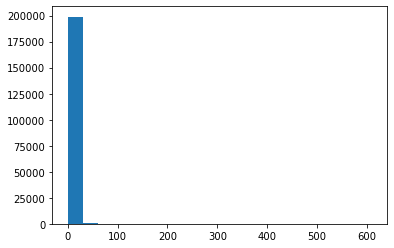

In [33]:
# Histogram of funny column to show class imbalances

fig, ax = plt.subplots(figsize = (6,4))

ax.hist(df.funny, bins = 20)

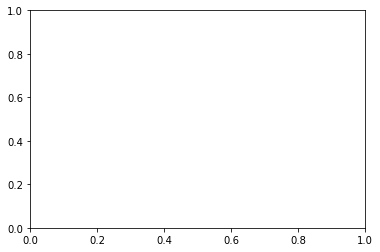

In [55]:
# Barchart of funny vs not funny

fig, ax = plt.subplots()


In [41]:
max(df.funny)

610

In [22]:
## change count to more if time

funny = []
not_funny = []

count = 100000
funny_threshold = 3
raw_data_path = 'yelp_dataset/yelp_academic_dataset_review.json'

with open(raw_data_path) as file:
    for line in file:
        # Break when we've created a balanced dataset with count reviews in each category
        if len(funny) == count and len(not_funny) == count:
            break
                    
        sample = {}
        reviews = json.loads(line)
        sample['text'] = reviews['text']
                    
        if reviews['funny'] >= funny_threshold and len(funny) < count:
            sample['label'] = 1
            funny.append(sample)
        elif reviews['funny'] < funny_threshold and len(not_funny) < count:
            sample['label'] = 0
            not_funny.append(sample)
                    

In [23]:
reviews = funny + not_funny

In [31]:
len(reviews)

200000

In [30]:
(reviews[0]['text'])

"I loved everything about this place. I've only been once but I keep meaning to go back as it was so great (just a bit out of my way). \n\nI went with a fairly large group so we'd all ordered something different (back when it was $6 for everything, it looks like they've changed that now). At the time I got the chickpea fries, which were delicious but watch out for the fiber because I had to sit out of an entire board game. The board game selection was great, and I love that they serve mead (though I didn't get any at 12 pm haha).  The molten lava chocolate cake was so, so good. Seriously.\n\nThe real topping to the experience (other than the great service and the fact that they put lemons in their complimentary ice water) was that they were playing Siouxsie and the Banshees in the background! That + board games + good food + mead = I'm a fan forever."

## Text Processing Pipeline ##

In [9]:
# create new df of just text and label

new_df = pd.concat([df.text, df.funny], axis=1)

In [10]:
new_df['funny or not'] = (new_df.funny >= 3).astype(int)

In [11]:
new_df = new_df.drop(columns ='funny')

In [12]:
new_df.head()

,text,funny or not
0,A scavenger hunt was hosted by the Paramount r...,1
1,The Pretty Kitty has 20 locations throughout t...,1
2,After a very productive business meeting this ...,1
3,I called in advance to be sure that they had t...,1
4,Eastern Standard reminds me of that scene in S...,1


## EDA ##


In [ ]:
# Distribution of review lengths

fig, ax = plt.subplots()
ax.hist()

In [95]:
# normalize data and remove accents

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii.decode()

In [97]:
review_text = new_df.text

In [123]:
review_text[0]

"A scavenger hunt was hosted by the Paramount recently. Plus 1.5 million stars. I almost ate pavement running around downtown Austin to win that thing with my team, and even though we didn't even get third, it was totally worth it. Watching the Big Lebowski afterwards on their lovely screen, sitting in their charming wooden seats, I marveled at what an awesome town Austin is and how many people appreciate events like that and structures like the Paramount. \n\nThis place bears a close resemblance to the old Broadway theaters where I used to dork out during my undergrad (theater minor).  It's a thrilling comfort every time I come here; I haven't found another such place. The mezzanine seats way on high still offer a great view of the screen, and an opportunity to admire the ceiling details. I finally saw Casablanca for the first time, thanks to the Paramount and their investment on keeping classics alive. What a fitting place to take in cinema royalty."

In [15]:
# create toy df for faster processing

funny_df = pd.read_csv('funny.csv')
not_funny_df = pd.read_csv('notfunny.csv')

df = pd.concat([funny_df, not_funny_df]).drop_duplicates('review_id')

In [48]:
toy_funny = funny_df.sample(n=10000, random_state=1)
toy_notfunny = not_funny_df.sample(n=10000, random_state=1)

toy_df = pd.concat([toy_funny, toy_notfunny]).drop_duplicates('review_id')
toy_df = toy_df.drop(['Unnamed: 0'], axis = 1)

In [51]:
toy_df.funny

43660     4
87278     3
14317     3
81932     3
95321    21
         ..
59828     0
47957     0
42429     0
76505     0
49578     0
Name: funny, Length: 20000, dtype: int64

In [52]:
toy = pd.concat([toy_df.text, toy_df.funny], axis=1)

toy['funny or not'] = (toy.funny >= 3).astype(int)
toy = toy.drop(columns ='funny')

In [55]:
toy.tail()

,text,funny or not
59828,Great local spot! Ribs were really tasty. Can'...,0
47957,We hired Jessica Cain with Savvy Sisters / Cha...,0
42429,I arrived on a saturday at exactly 5pm not kno...,0
76505,We just had a lovely breakfast and fantastic l...,0
49578,I've been to this Kwik Kar a few times to have...,0


In [56]:
toy[toy['funny or not'] == 1]

,text,funny or not
43660,I have this lunch pass deal where I can litera...,1
87278,NO USE OF GLOVES or HAIR NETS---- gross!\nThey...,1
14317,OK srsly. FIX THE DOOR! It's freaking winter p...,1
81932,When asked what I will miss the most about Ohi...,1
95321,"Yes, it's a bit of a tourist trap, and yes, th...",1
...,...,...
59828,"Vivian, the owner, saw my previous review and ...",1
47957,Way to bone yourself out of a good review.\n\n...,1
42429,This is my first time traveling from Seattle t...,1
76505,"Overpriced fake fine dining that takes the ""el...",1


In [ ]:
# gensim library for word vectors - come back if time

In [18]:
toy2 = toy.copy()

In [19]:
toy2['text'] = review_text.map(remove_accents)

NameError: name 'review_text' is not defined

In [111]:
# create a single class that does text processing

In [254]:
# Tokenization (don't filter stopwords or punctuation as these may contribute to humor)

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

#tokens = review_text.map(word_tokenize)

#tokenized = [word_tokenize(review_text.lower()) for review in review_text]

# lowercase and tokenize
toy_df['tokens'] = toy_df['text'].str.lower().map(word_tokenize)

In [175]:
type(toy_df)

pandas.core.frame.DataFrame

In [189]:
# stemming/lemmatization

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

porter = PorterStemmer()
snowball = SnowballStemmer('english')
wordnet = WordNetLemmatizer()

# docs_porter = [[porter.stem(word) for word in words]
#                for doc in toy_tokens]
# docs_snowball = [[snowball.stem(word) for word in words]
#                  for doc in toy_tokens]
# docs_wordnet = [[wordnet.lemmatize(word) for word in words]
#                 for doc in toy_tokens]

tokens_porter = [list(map(porter.stem, doc)) for doc in toy_df['tokens']]

tokens_snowball = [list(map(snowball.stem, doc)) for doc in toy_df['tokens']]

tokens_wordnet = [list(map(wordnet.lemmatize, doc)) for doc in toy_df['tokens']]


In [191]:
# stem/lemmatize within dataframe

type(tokens_porter)

list

In [194]:
len(tokens_wordnet[0])

186

In [195]:
## Print the stemmed and lemmatized words from the first review for each method
print("%16s %16s %16s %16s" % ("word", "porter", "snowball", "lemmatizer"))

for i in range(min(len(tokens_porter[0]), len(tokens_snowball[0]), len(tokens_wordnet[0]))):
    p, s, w = tokens_porter[0][i], tokens_snowball[0][i], tokens_wordnet[0][i]
    if len(set((p, s, w))) != 1:
        print("%16s %16s %16s %16s" % (toy_df['tokens'][0][i], p, s, w))


            word           porter         snowball       lemmatizer
       scavenger          scaveng          scaveng        scavenger
             was               wa              was               wa
          hosted             host             host           hosted
        recently           recent           recent         recently
            plus              plu             plus             plus
         running              run              run          running
             was               wa              was               wa
         totally            total            total          totally
        watching            watch            watch         watching
      afterwards        afterward        afterward       afterwards
          lovely             love             love           lovely
         sitting              sit              sit          sitting
        charming            charm            charm         charming
        marveled           marvel           marv

## TF-IDF Vectorization ##

In [200]:
# bag of words, max features 500
# TF-IDF
# will go with lemmatizer to preserve as much of the original word as possible

from sklearn.feature_extraction.text import TfidfVectorizer

def tokenize(doc):
    '''
    INPUT: string
    OUTPUT: list of strings

    Remove accents, tokenize, and lemmatize the document.
    '''
    doc = remove_accents(doc)
    return [wordnet.lemmatize(word) for word in word_tokenize(doc.lower())]


tfidfvect = TfidfVectorizer(tokenizer=tokenize)

# features
tfidf_vectorized = tfidfvect.fit_transform(toy_df.text)

In [218]:
tfidf_vectorized

<5000x32912 sparse matrix of type '<class 'numpy.float64'>'
	with 641428 stored elements in Compressed Sparse Row format>

In [206]:
words_tfidf = tfidfvect.get_feature_names()

In [212]:
words_tfidf

['!',
 '#',
 '$',
 '%',
 '&',
 "'",
 "''",
 "'03",
 "'08",
 "'33",
 "'40s",
 "'50",
 "'50s",
 "'67-'83",
 "'70s",
 "'75",
 "'80",
 "'80s",
 "'90s",
 "'97",
 "'actually",
 "'aged",
 "'air-bag",
 "'allowed",
 "'almost-corporate",
 "'amazing",
 "'ambiance",
 "'app",
 "'ass-ertive",
 "'assertive",
 "'austin",
 "'average",
 "'awesome",
 "'badonkadonk",
 "'bam",
 "'banker",
 "'best",
 "'blank",
 "'blast",
 "'blood",
 "'blown",
 "'boring",
 "'boujee",
 "'bout",
 "'boy",
 "'brasserie",
 "'bread",
 "'bro",
 "'buck",
 "'build",
 "'burbs",
 "'burnt",
 "'but",
 "'cause",
 "'check",
 "'cheese",
 "'chocolate",
 "'classic",
 "'cleaning",
 "'coffee",
 "'concept",
 "'conservative",
 "'cosby",
 "'could",
 "'couve",
 "'cove",
 "'crispy",
 "'crusting",
 "'ctj",
 "'curds",
 "'cuse",
 "'d",
 "'daycation",
 "'deep",
 "'designer",
 "'desperation",
 "'did",
 "'dine",
 "'earthy",
 "'electric",
 "'elevator",
 "'em",
 "'etta",
 "'every",
 "'excellent",
 "'exceptional",
 "'fad",
 "'famous",
 "'favourite",
 "'fine"

In [216]:
tfidf_vectorized[0, words_tfidf.index('blast')]

0.0

In [1]:
# N-grams
# bi-grams and tri-grams


In [ ]:
# part of speech tagging

from nltk import pos_tag


In [ ]:
# latent semantic analysis


## Exploratory Data Analysis ##

## Modeling ##

In [22]:
# Recurrent Neural Network

# K-folds

# baseline model on top of bag-of-words

# split into train and test sets

from sklearn.model_selection import train_test_split

def split_data(X, y, test_size=0.2):
    '''Performs a train-test split on the X and y data, returning:
    X_train, X_test, y_train, y_test in that order.
    default split should be 80%-20%
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    return X_train, X_test, y_train, y_test


In [57]:
X_train, X_test, y_train, y_test = split_data(toy['text'], toy['funny or not'], test_size = 0.2)

In [75]:
tfidf = TfidfVectorizer(max_features = 5000, sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))
#features = tfidf.fit_transform(toy_df.text).toarray()

# try max features 3000, 10000 etc. to see if improving
# n-grams: 1, 2, 3
# stopwords 
# stemming, lemma etc.

# tfidf_vect = TfidfVectorizer(tokenizer=tokenize)



In [76]:
X_train_tfidf = tfidf.fit_transform(X_train)

In [77]:
X_train_tfidf

<16000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 1858894 stored elements in Compressed Sparse Row format>

In [78]:
X_test_tfidf = tfidf.transform(X_test)

In [79]:
X_test_tfidf

<4000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 465133 stored elements in Compressed Sparse Row format>

In [80]:
X_train_tfidf.shape, X_test_tfidf.shape

((16000, 5000), (4000, 5000))

### Logistic Regression ###

In [121]:
# logistic regression

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score

model1 = LogisticRegression(random_state=0)
model1.fit(X_train_tfidf, y_train)
y_pred = model1.predict(X_test_tfidf)
y_proba = model1.predict_proba(X_test_tfidf)[:,1]


In [122]:
y_pred

array([0, 0, 0, ..., 1, 0, 1])

In [123]:
y_proba

array([0.45898722, 0.26072752, 0.37130948, ..., 0.91955303, 0.17203727,
       0.81870562])

In [103]:
model1.score(X_train_tfidf, y_train)

0.8191875

In [124]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7475


In [125]:
print("Precision:", precision_score(y_test, y_pred))

Precision: 0.7443721860930466


In [126]:
print("Recall:",recall_score(y_test, y_pred))

Recall: 0.7488676396577756


In [97]:
# model2 = LogisticRegressionCV(cv=5, random_state=0)
# model2.fit(X_train_tfidf, y_train)

# y_pred2 = model2.predict(X_test_tfidf)
# y_predproba2 = model1.predict_proba(X_test_tfidf)

/Users/kellyz/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kellyz/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/Users/kellyz/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kellyz/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

In [100]:
len(y_predproba2)

4000

In [131]:
# Model Evaluation

# ROC curve

fpr, tpr, threshold = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

In [153]:
# confusion matrix

conf_mat = confusion_matrix(y_test, y_pred)
conf_mat
# true positive, false negative
# false positive, true negative

array([[1502,  511],
       [ 499, 1488]])

In [132]:
roc_auc

0.8244248319491498

In [151]:
len(fpr)

1339

In [134]:
def plot_ROC(ax, fpr, tpr):
    ax.plot([1]+list(fpr), [1]+list(tpr), label="ROC")
    ax.plot([0,1],[0,1], 'k', label="random")
    ax.set_xlabel('fpr')
    ax.set_xlabel('fpr')
    ax.set_ylabel('tpr')
    ax.set_title('ROC Curve')
    ax.legend()

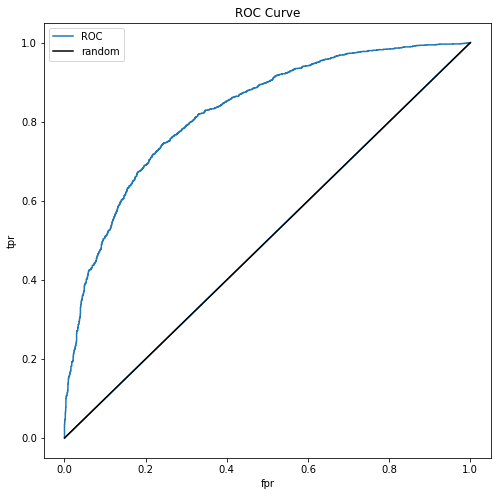

In [136]:
fig, ax = plt.subplots(figsize = (8,8))

plot_ROC(ax, fpr, tpr)

In [137]:
# Precision/Recall Curve

def plot_precision_recall(ax, tpr, precision):
    ax.plot(tpr, precision, label='precision/recall')
    #ax.plot([0,1],[0,1], 'k')
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision/Recall Curve')
    ax.plot([0,1],[precision[0],precision[0]], 'k', label='random')
    ax.set_xlim(xmin=0,xmax=1)
    ax.set_ylim(ymin=0,ymax=1)

In [152]:
# fig, ax = plt.subplots(figsize = (8,8))

# precision = conf_mat[0][0]/(conf_mat[0][0] + conf_mat[1][0])
# plot_precision_recall(ax, tpr, precision)

In [148]:
conf_mat[0][0]/(conf_mat[0][0] + conf_mat[1][0]) # precision

0.750624687656172

### Random Forest ###

In [ ]:
from sklearn.ensemble import RandomForestClassifier



### Gradient Boosting ###

## Model Evaluation ##

In [133]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score
# see diagonals, if any improvement in recall and precision

conf_mat = confusion_matrix(y_test, y_pred)

# fig, ax = plt.subplots(figsize = (10,8))
# sns.heatmap(conf_mat, annot=True, xticklabels = toy['funny or not'], yticklabels = toy['funny or not'])
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.show()


## Deep Learning ##

In [ ]:
# Feedforward Networks on top of BOW representation
# 25 epochs, batch size 50?


In [ ]:
# Convolutional Network?